# EE4211 Project - Question 1

Group name:

Group members: Liu Tianshu, Nie Hongtuo, Pan Jie, Zhang Chenxi

## Question 1.1 - Part 1 Calculate house number

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns

In [2]:
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv')
df

,localminute,dataid,meter_value
0,2015-10-01 00:00:10-05,739,88858
1,2015-10-01 00:00:13-05,8890,197164
2,2015-10-01 00:00:20-05,6910,179118
3,2015-10-01 00:00:22-05,3635,151318
4,2015-10-01 00:00:22-05,1507,390354
...,...,...,...
1584818,2016-03-31 23:59:14.336743-05,2129,201726
1584819,2016-03-31 23:59:17.427165-05,2945,161232
1584820,2016-03-31 23:59:35.370782-05,9729,138146
1584821,2016-03-31 23:59:47.816286-05,5129,166488


First let's get the number of houses.

In [3]:
grouped = df.groupby(['dataid'])
len(grouped)

157

We have gas flow meters installed in 157 houses.

## Question 1.1 - Part 2 Find decreasing values

Now we can find the anomaly samples in the data.

Now we can find the anomaly samples in the data. We think the meter that has at least one of the following two features should be a candidate of malfunctioning meter:
1. it sends a decreasing value
2. it keeps not updated for more than a certain period

Let's now have a look at the feature 1 first:

In [4]:
def find_decrease(df):
    grouped = df.groupby(['dataid'])
    decrease_meter_id = []
    for key,group in grouped:
        val = group.meter_value.values
        diff = val[1:] - val[:-1]
        decrease_time_id = np.where(diff < 0)[0] + 1
        if len(decrease_time_id):
            decrease_meter_id.append(key)
            decrease_time = group.localminute.values[decrease_time_id]
            print('The glitches of gas meter No.', key, 'happened in the moments below:\n')
            print(decrease_time, '\n')
    return decrease_meter_id

In [5]:
defect_id = find_decrease(df)

The glitches of gas meter No. 35 happened in the moments below:

['2015-10-20 09:00:12-05'] 

The glitches of gas meter No. 77 happened in the moments below:

['2015-10-20 20:20:55-05'] 

The glitches of gas meter No. 94 happened in the moments below:

['2015-11-01 01:11:10-06' '2015-11-01 01:17:53-06'
 '2015-11-01 01:23:12-06' '2016-01-16 10:23:43.197562-06'
 '2016-01-18 11:19:47.220413-06' '2016-01-18 11:26:52.211985-06'] 

The glitches of gas meter No. 483 happened in the moments below:

['2015-10-21 00:18:54-05'] 

The glitches of gas meter No. 484 happened in the moments below:

['2015-11-01 01:18:29-06' '2015-11-01 01:34:43-06'
 '2015-11-01 01:40:00-06' '2015-11-01 01:44:34-06'
 '2015-11-01 01:48:31-06' '2015-11-01 01:55:28-06'
 '2016-03-05 00:01:58.770374-06' '2016-03-05 01:43:22.133007-06'
 '2016-03-05 01:57:57.625975-06'] 

The glitches of gas meter No. 1042 happened in the moments below:

['2015-10-07 14:32:08-05'] 

The glitches of gas meter No. 1086 happened in the moments 

In [6]:
print('The ID of the', len(defect_id), 'defective meters are:\n')
print(defect_id)

The ID of the 43 defective meters are:

[35, 77, 94, 483, 484, 1042, 1086, 1185, 1507, 1556, 1718, 1790, 1801, 2129, 2335, 2449, 3134, 3527, 3544, 3893, 4031, 4193, 4514, 4998, 5129, 5131, 5193, 5403, 5810, 5814, 5892, 6836, 7017, 7030, 7117, 7739, 7794, 7989, 8156, 8890, 9134, 9639, 9982]


43 gas meters have sent values that decreased at some point.
Let's look inside the data series given by a defective meter, for example, gas meter No.9982.

In [7]:
def plot_group(key,df):
    grouped = df.groupby(['dataid'])
    group = grouped.get_group(key)
    t = group.localminute.values
    val = group.meter_value.values
    # keep the date
    t = map(lambda s : s[0:10], t)
    t = np.array(list(t))
    
    s = pd.Series(val, index=t)
    s.plot(figsize=(16, 8))
    plt.rcParams['figure.dpi'] = 300
    plt.xticks(rotation=-20)
    plt.title('Gas Meter No.' + str(key))
    return

/opt/anaconda3/envs/ee4211/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


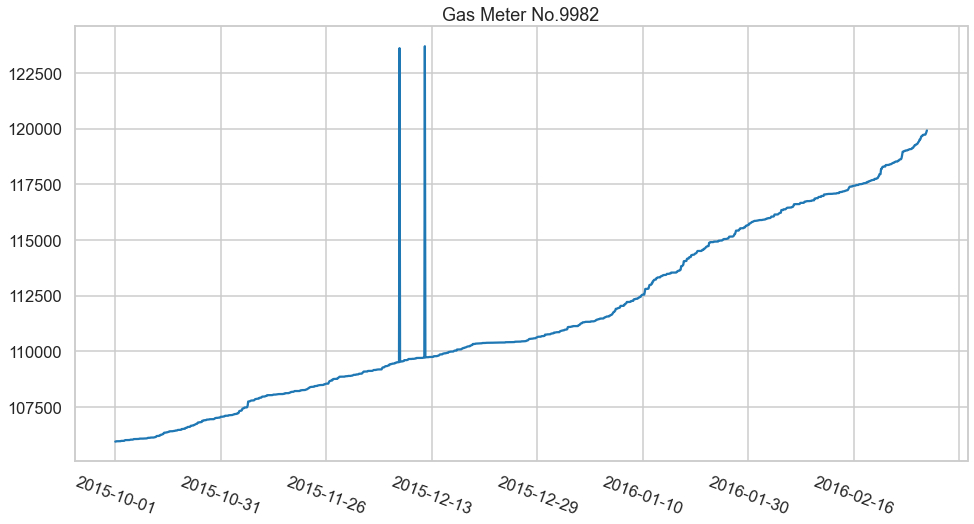

In [8]:
sns.set_style("whitegrid")
sns.set_context("talk")
plot_group(9982,df)

## Question 1.1 - Part 3 Details on decreasing values

Let's now extract more information from the meters that have sent decreasing value.

For each one of these meters,we want to know:

1. how many times and how often it happened to send a decreasing value
2. when it sends these decreasing values
3. the minimum, maximum and average of these decreasing value
4. when the maximum decrease/drop happends

In [9]:
defective_id = df[df['dataid'].isin(defect_id)]  
defective_id = defective_id.groupby(['dataid'])
defective_id_list = list(defective_id)

defective_id_num = len(defect_id)         # the number of defective dataid
defective_value = [0]*defective_id_num    # the value of decrease/drop
defective_num = [0]*defective_id_num      # the times of decreasing/drop
defective_time = [0]*defective_id_num     # the time when decrease/drop happen
report_num = [0]*defective_id_num         # the times of sending/reporting value
defect_rate = [0]*defective_id_num        # the rate of drop/decrease

In [10]:
# to get when the malfunction happened, their corresponding value of drop/decrease, and the freaquency/rate of malfunction
for i in range(defective_id_num):
    datalst = defective_id_list[i][1]
    datanum = len(datalst)
    count = 0
    Value = []
    Time = []
    report_num[i] = datanum
    for j in range(datanum-1):
        if datalst.iat[j+1,2] < datalst.iat[j,2]:
            #if the latter value is smaller than the former one, we think malfunction happends
            drop = datalst.iat[j,2] -  datalst.iat[j+1,2] # the value of decrease/drop 
            Value.append(drop)
            Time.append(datalst.iat[j+1,0]) # the time when decrease/drop happends
            count = count + 1      
    defective_num[i] = count  
    defective_value[i] = Value
    defective_time[i] = Time
    defect_rate[i] = defective_num[i]*100/report_num[i] # the frequency/rate of malfunction

In [11]:
drop_sta = [0]*defective_id_num #the max, min and average of the value of drop/decrease
drop_max_time = [0]*defective_id_num #the time when the most severe drop happends

for i in range(defective_id_num):
    drop_sta[i] = [max(defective_value[i]),min(defective_value[i]),round(sum(defective_value[i])/len(defective_value[i]),2)] #max min mean
    index = np.where(defective_value[i]==np.max(defective_value[i])) #the time when the most severe drop happends
    max_happened_time = index[0]
    max_num = len(max_happened_time)
    maxtime = []
    for j in range(max_num):
        maxtime.append(defective_time[i][j])
    drop_max_time[i] = maxtime

Now we get the report times, malfunction times, malfunction frequency/rate of these dataid, we also get ot know when these malfunction happends, the specific value (the value of drop/decrease) of each malfunction. Moreover, we also get the max, min and average of the value of drop/decrease, and find the time when the severe drop/decrease happend.

You can print these information above for every single *dataid* one by one.

In [12]:
#----------print these information one by one-------------
for i in range(defective_id_num):
    print('dataid:',defect_id[i],)
    print('report times:',report_num[i])
    print('defect times:',defective_num[i]) 
    print('defect rate(%):',defect_rate[i])
    print('min drop:',drop_sta[i][1])
    print('average drop:',drop_sta[i][2])
    print('max drop:',drop_sta[i][0],',happened at',drop_max_time[i])
    print(' ')
    print('------------------------------')
    print('------------------------------')
    print(' ')

dataid: 35
report times: 11872
defect times: 1
defect rate(%): 0.008423180592991913
min drop: 2
average drop: 2.0
max drop: 2 ,happened at ['2015-10-20 09:00:12-05']
 
------------------------------
------------------------------
 
dataid: 77
report times: 10683
defect times: 1
defect rate(%): 0.009360666479453337
min drop: 2
average drop: 2.0
max drop: 2 ,happened at ['2015-10-20 20:20:55-05']
 
------------------------------
------------------------------
 
dataid: 94
report times: 36335
defect times: 6
defect rate(%): 0.016513003990642632
min drop: 4
average drop: 9.0
max drop: 12 ,happened at ['2015-11-01 01:11:10-06', '2015-11-01 01:17:53-06']
 
------------------------------
------------------------------
 
dataid: 483
report times: 27628
defect times: 1
defect rate(%): 0.003619516432604604
min drop: 14
average drop: 14.0
max drop: 14 ,happened at ['2015-10-21 00:18:54-05']
 
------------------------------
------------------------------
 
dataid: 484
report times: 44034
defect ti

You can also see the summary table for these meters:

In [13]:
#----------also see the summary table----------------
data_summary = {'dataid':defect_id,'report times':report_num,'malfunction times':defective_num,'malfunction rate(%)':defect_rate,'max/min/average drop':drop_sta,'max drop happened at':drop_max_time}
data_summary = pd.DataFrame(data_summary)
data_summary

,dataid,report times,malfunction times,malfunction rate(%),max/min/average drop,max drop happened at
0,35,11872,1,0.008423,"[2, 2, 2.0]",[2015-10-20 09:00:12-05]
1,77,10683,1,0.009361,"[2, 2, 2.0]",[2015-10-20 20:20:55-05]
2,94,36335,6,0.016513,"[12, 4, 9.0]","[2015-11-01 01:11:10-06, 2015-11-01 01:17:53-06]"
3,483,27628,1,0.003620,"[14, 14, 14.0]",[2015-10-21 00:18:54-05]
4,484,44034,9,0.020439,"[6, 2, 2.44]",[2015-11-01 01:18:29-06]
5,1042,3830,1,0.026110,"[2, 2, 2.0]",[2015-10-07 14:32:08-05]
6,1086,30029,1,0.003330,"[2, 2, 2.0]",[2015-11-01 01:32:25-06]
7,1185,18456,135,0.731469,"[17798, 2, 16267.67]","[2015-10-17 10:51:09-05, 2015-10-17 11:08:06-05]"
8,1507,32603,2,0.006134,"[2, 2, 2.0]","[2015-11-01 01:39:26-06, 2015-11-01 01:57:27-06]"
9,1556,3690,12,0.325203,"[16374, 2, 13574.0]","[2015-10-17 12:01:05-05, 2015-11-01 01:30:39-06]"


## Question 1.1 - Part 4 Find stagnant values

Besides feature 1, we now consider feature 2, the situation that a meter keeps not updated for a long time (like 10 days), this kind of meters might also be malfunctioning.

In [14]:
grouped_list = list(grouped)
interval_threshold = 240 #if a meter has not updated itself more than this threshold (hours)
                             #we think it is a candidate of faulted meter

In [15]:
#This functino is to compute the interval(hours) between 2 time points

def time_interval(time1,time2):
    year1 = int(time1[:4])
    year2 = int(time2[:4])
    month1 = int(time1[5:7])
    month2 = int(time2[5:7])
    day1 = int(time1[8:10])
    day2 = int(time2[8:10])
    hour1 = int(time1[11:13])
    hour2 = int(time2[11:13])
    interval = hour2-hour1 + 24*(day2-day1) + 24*30*(month2-month1) + 24*30*12*(year2-year1)
    return interval

In [16]:
#This function is to find these meters which has kept not updated for more than a certain long time 

def long_time_no_update(List,interval_hours):
    
    IDnum = len(List)
    List_unchanged_id = []
    List_unchanged_time = []
    for i in range(IDnum):
        idnum = len(List[i][1])
        unchanged_time = []
        for j in range(idnum-1):
            t1 = List[i][1].iat[j,0]
            t1 = t1[:19]
            t2 = List[i][1].iat[j+1,0]
            t2 = t2[:19]
            if time_interval(t1,t2) > interval_hours:
                unchanged_time.append([t1,t2])
        if unchanged_time != []:
            List_unchanged_id.append(List[i][0])
            List_unchanged_time.append(unchanged_time)
    return [List_unchanged_id,List_unchanged_time]


Let's see the dataid of these meters that has not updated for a long time.

In [17]:
[unchanged_id,unchanged_time] = long_time_no_update(grouped_list,interval_threshold)
print('The dataid of the meter(s) that keep not updated for more than',interval_threshold,'hour(s):')
print(unchanged_id)
report_times = []
for i in range(len(unchanged_id)):
    report_times.append(list(df['dataid']).count(unchanged_id[i]))

KeyboardInterrupt: 

## Question 1.1 - Part 5 Details on stagnant values

You can also use the code below to see more detailed information about these meters, along with the time periods where they were malfunctioning.

In [ ]:
for i in range(len(unchanged_id)):
    print(' ')
    print('---------------------------------------')
    print('dataid:',unchanged_id[i])
    print('it has reported',report_times[i],'value(s) in total')
    print('it happened',len(unchanged_time[i]),'time(s) that this meter keeps not updated for more than',interval_threshold,'hour(s)')
    for j in range(len((unchanged_time[i]))):      
                   print('keeps not updated from',unchanged_time[i][j][0],'to',unchanged_time[i][j][1])
    print(' ')
    print('---------------------------------------')

And the corresponding summary table:

In [ ]:
long_stop_times = []
for i in range(len(unchanged_id)):
    long_stop_times.append(len(unchanged_time[i]))
    
data_summary = {'dataid':unchanged_id,'report times':report_times,'Long stop time(s)':long_stop_times}
data_summary = pd.DataFrame(data_summary)
data_summary

To sum up, we now get all these candidates of malfunctioning meters:

In [ ]:
print('The dataid of meters (', len(defect_id), 'in total ) that send a decreasing values are as follows:\n')
print(defect_id)
print(' ')
print('The dataid of meters (', len(unchanged_id), 'in total ) that has not updated for more than',interval_threshold,'hour(s) are as follows:\n')
print(unchanged_id)
print('')
print('The dataid of all possible candidates (', len(list(set(defect_id+unchanged_id))), 'in total ) of malfunctioning meter are as follows:\n')
print(list(set(defect_id+unchanged_id)))

## Question 1.2 - Part 1 Data preprocessing

Since there are glitches in some of the data series, we need to smooth the data first.
There are 2 kinds of glitches: sudden increase and slight decrease, both of which are shown below. The slight decrease can be hard to spot for human eyes, but can be seen in the printed data samples below the figure. We will replace the impulses and fluctuations with the last available values before them.

Note that we decided not to take summer time into consideration, since time zone will not affect the way how people consume the gas. A family that usually cook at 7 pm will still cook at 7 no matter summer time is used or not.

/opt/anaconda3/envs/ee4211/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/opt/anaconda3/envs/ee4211/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


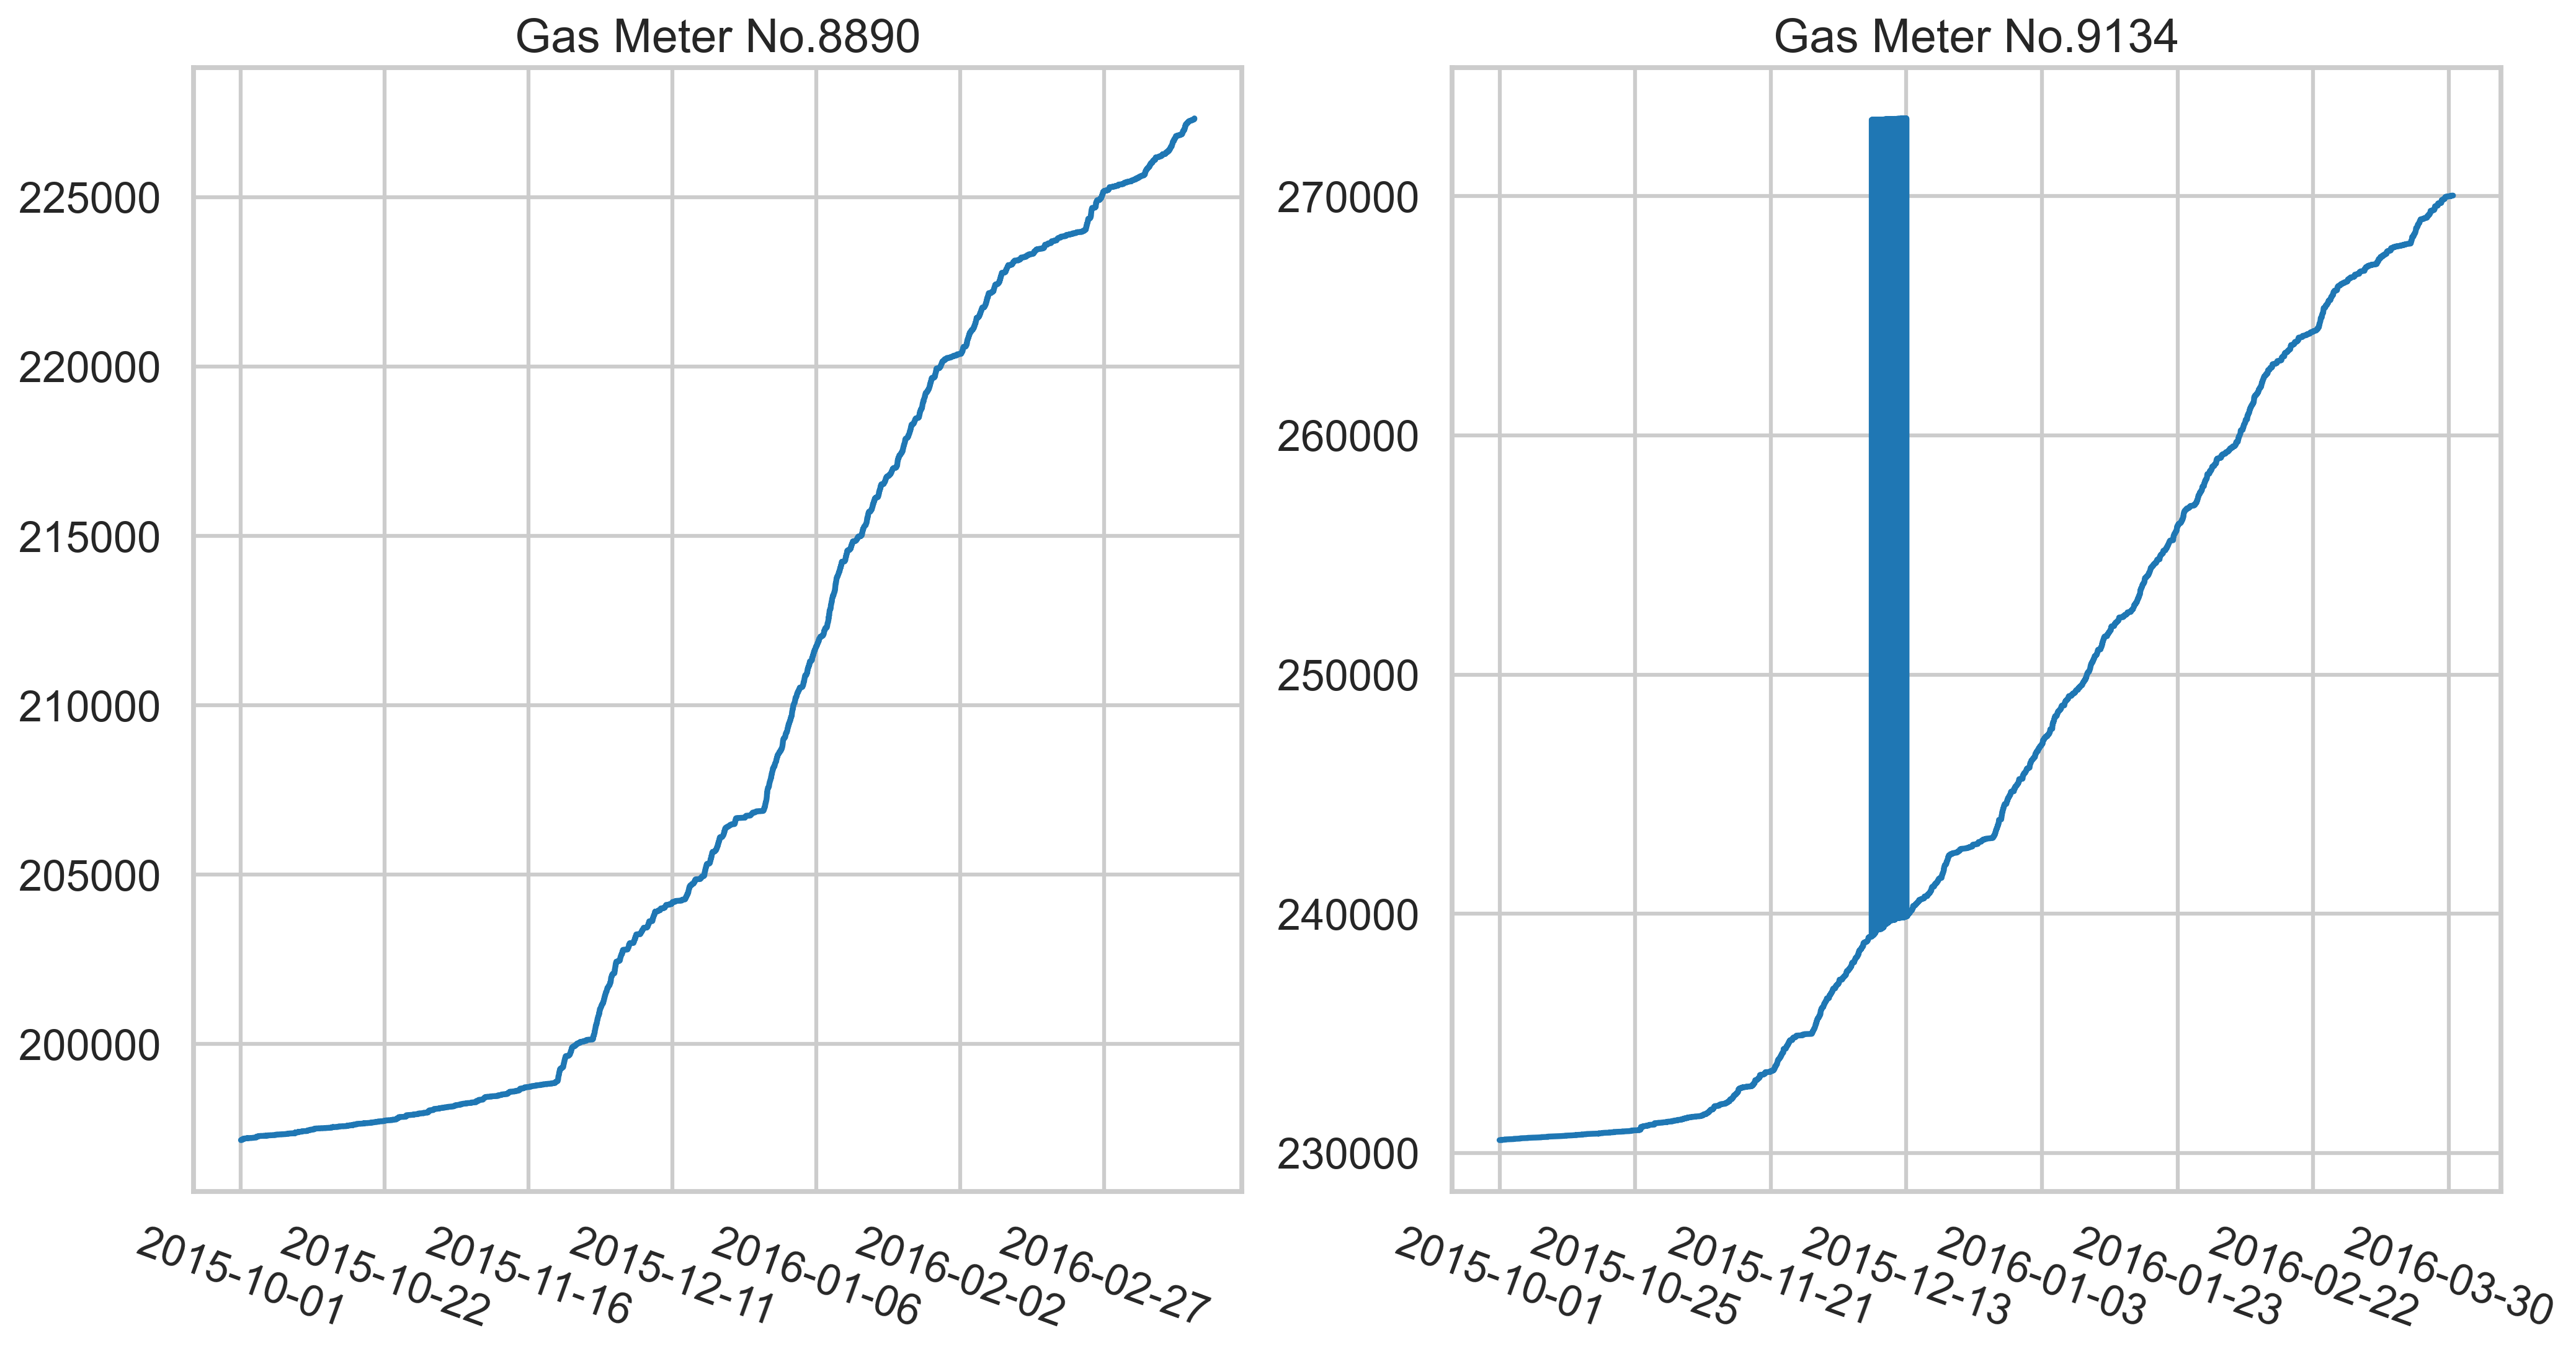

In [18]:
plt.subplot(121)
plot_group(8890,df)

plt.subplot(122)
plot_group(9134,df)

Here are the data samples before and after the time when glitches happened. All values under each **ID** is smaller than those under **ID - 1**.

In [19]:
def find_decrease_details(df):
    decrease_details = []
    grouped = df.groupby(['dataid'])
    for key,group in grouped:
        val = group.meter_value.values
        diff = val[1:] - val[:-1]
        decrease_time_id = np.where(diff < 0)[0] + 1
        if len(decrease_time_id):
            for id in decrease_time_id:
                decrease_details.append([key, id, val[id-3], val[id-2], val[id-1], val[id], val[id+1]])
    labels = ['Gas Meter ID', 'Sample ID', 'ID - 3','ID - 2', 'ID - 1', 'ID + 0', 'ID + 1']
    decrease_details_df = pd.DataFrame(decrease_details, columns=labels)
    return decrease_details_df

In [20]:
decrease_details_df = find_decrease_details(df)
# pd.set_option('display.max_rows', None)
# uncomment this to get full output
decrease_details_df
# pd.set_option('display.max_rows', 15)
# reset the output limit

,Gas Meter ID,Sample ID,ID - 3,ID - 2,ID - 1,ID + 0,ID + 1
0,35,958,93998,93998,94014,94012,94014
1,77,1518,59254,59254,59260,59258,59262
2,94,7380,117626,117626,117626,117614,117626
3,94,7383,117614,117626,117626,117614,117626
4,94,7385,117626,117614,117626,117616,117620
...,...,...,...,...,...,...,...
1301,9134,6002,239886,239888,273252,239888,239888
1302,9639,8584,227322,227322,256814,227328,227328
1303,9639,8630,227548,227548,256814,227548,227550
1304,9982,540,109512,109512,123622,109532,109542


Now let's get the data prettier.

In [21]:
def rectify(df):
    grouped = df.groupby(['dataid'])
    for key,group in grouped:
        val = group.meter_value.values
        diff = val[1:] - val[:-1]
        defect_time = np.where(diff < 0)[0] + 1
        if len(defect_time):
            for i in range(1,len(val)):
                if val[i] > val[-1]:
                    val[i] = val[i - 1]
                elif val[i] < val[i - 1]:
                    val[i] = val[i - 1]
            df.loc[df['dataid'] == key, 'meter_value'] = val
    return df

In [22]:
df = rectify(df)

Then we can recheck if there are any decreasing data samples in our dataset.

In [23]:
defect_id = find_decrease(df)
len(defect_id)

0

There isn't any decreasing anymore! We can see the difference from the two figures below.

/opt/anaconda3/envs/ee4211/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/opt/anaconda3/envs/ee4211/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


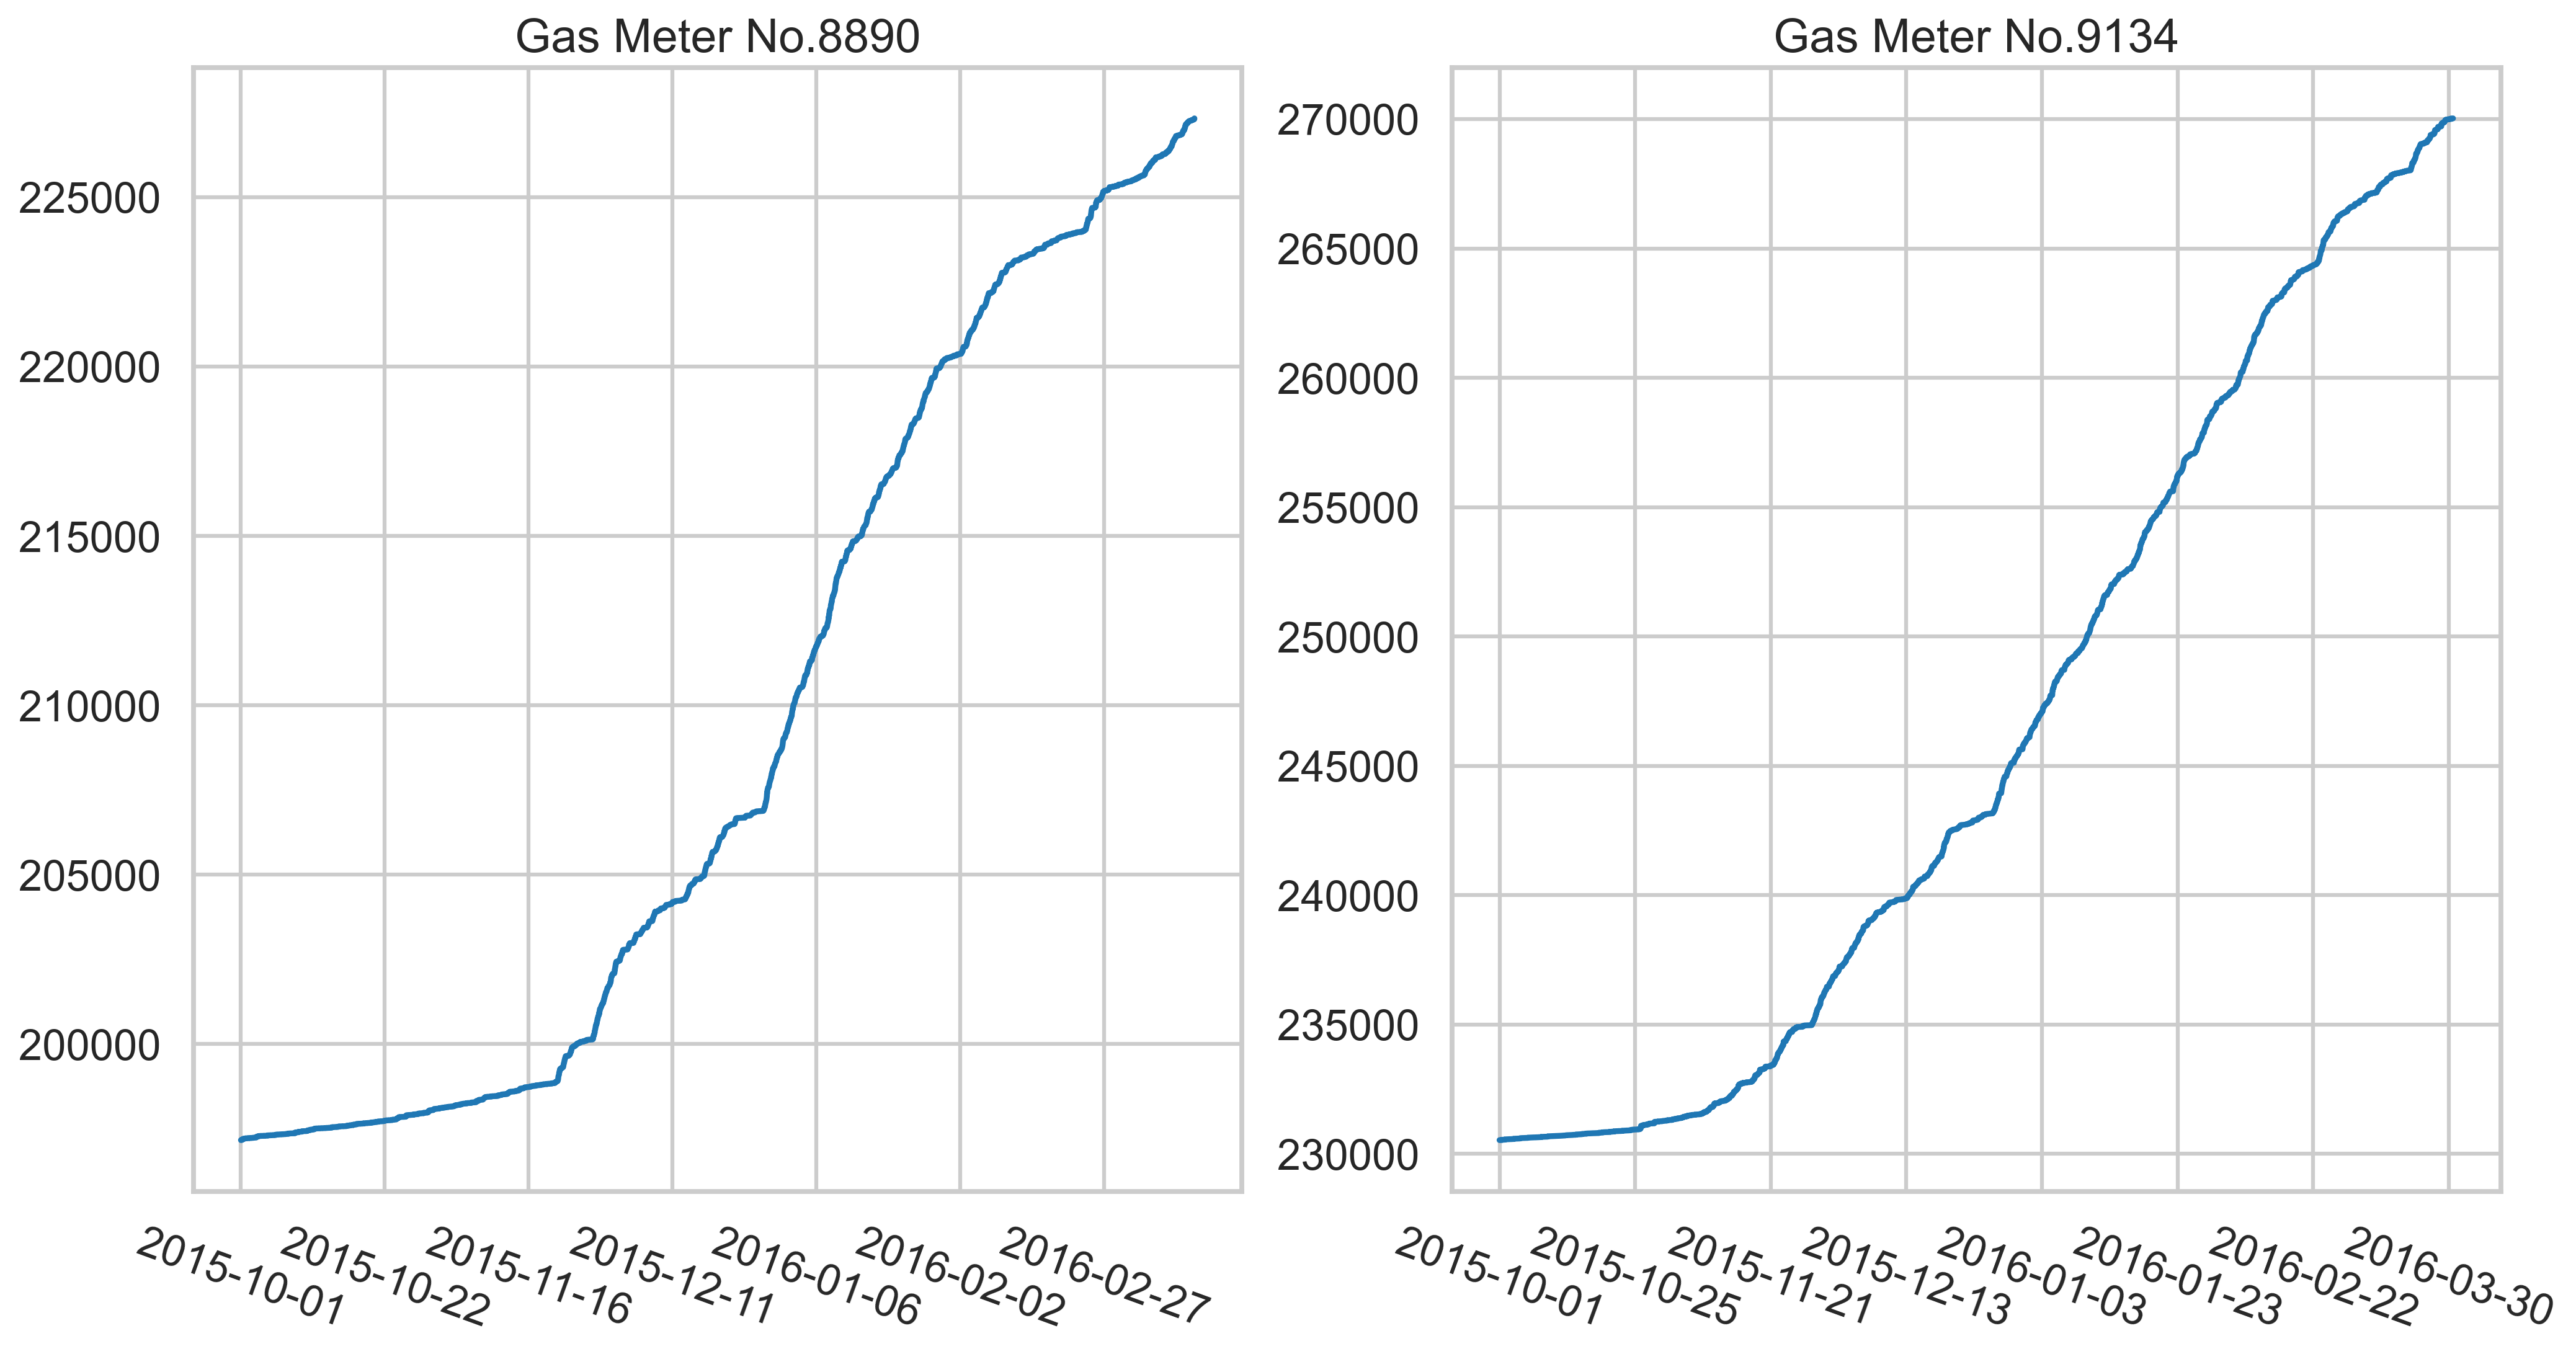

In [24]:
plt.subplot(121)
plot_group(8890,df)

plt.subplot(122)
plot_group(9134,df)

## Question 1.2 - Part 2 Hourly usage grouped by month

In [25]:
# turn into timestamp
def local2utc(time):
    return pd.Timestamp(time)
df.localminute = df.apply(lambda r: local2utc(r.localminute), axis=1)

In [ ]:
def select_data(df, month) -> pd.DataFrame:
    column_names = df.columns.values
    values = df.values
    values = filter(lambda x: x[0].month == month, values)
    values = pd.DataFrame(values)
    for i in range(len(column_names)):
        values = values.rename(columns={i:column_names[i]})
    return values

In [ ]:
## select Oct data
month_data = select_data(df, 10)
month_data

In [ ]:
def hourly_data_by_group(df, month) -> set():
    month_dict = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    groups = df.groupby(['dataid'], sort=['localminute'])
    processed_group = {}
    for key in groups.groups.keys():
        new_group = []
        current_group = groups.get_group(key).values
        # init_first_point
        first_point = current_group[0]
        first_point[0] = first_point[0].replace(day = 1, hour = 0, minute = 0, second = 0)
        index_current_group = 0
        tmp = []
        # replace all time on the hour
        for row in current_group:
            row[0] = row[0].replace(minute = 0, second = 0)
            tmp.append(row)
        current_group = tmp
        # interpolate data 24 hour for 30 day
        for day in range(1, month_dict[month] + 1):
            for hour in range(0, 24):
                # make sure its the last data of the current time
                while (True):
                    if (index_current_group >= len(current_group)):
                        break
                    current_row = current_group[index_current_group]
                    time = current_row[0]
                    if (time.day == day and time.hour == hour):
                        index_current_group += 1
                    else:
                        break
                # assign data
                current_row = current_group[index_current_group - 1]
                time = current_row[0]
                date = pd.Timestamp(year = time.year, month = time.month, day = time.day, hour = time.hour, minute = 0, second = 0)
                current_row = [date, current_row[1], current_row[2]]
                if (time.day == day and time.hour == hour):
                    if (len(new_group) > 0 and new_group[-1][0].day == day and new_group[-1][0].hour == hour):
                        new_group[-1] = current_row
                    else:
                        new_group.append(current_row)
                else:
                    date = pd.Timestamp(year = time.year, month = time.month, day = day, hour = hour, minute = 0, second = 0)
                    row = [date,new_group[-1][1],new_group[-1][2]]
                    new_group.append(row)
        processed_group[key] = new_group
    return processed_group

Then we can fetch the data conveniently by setting the month and meter ID we need.

In [ ]:
hourly_data_groups = hourly_data_by_group(month_data, 10)
keys = hourly_data_groups.keys() # show all the available meter id
print('Meter IDs from 157 houses:\n', keys, '\n')

In [ ]:
import calendar

def to_data_frame(data_list):
    labels = ['localminute', 'dataid', 'meter_value']
    df = pd.DataFrame(data_list, columns=labels)
    return df

def plot_month(key,month,df):
    month_data = select_data(df, month)
    hourly_data_groups = hourly_data_by_group(month_data, month)
    month_df = to_data_frame(hourly_data_groups[key])
    
    grouped = month_df.groupby(['dataid'])
    group = grouped.get_group(key)
    t = group.localminute.values
    val = group.meter_value.values
    
    s = pd.Series(val, index=t)
    s.plot(figsize=(16, 8))
    plt.xticks(rotation=-20)
    plt.title('Gas Meter No.' + str(key) + ' in ' + calendar.month_name[month])
    return

In [ ]:
# set the key and month as you like

month = 10 # data from Oct
key = 35 # gas meter no.35
plot_month(key,month,df)

## Question 1.3 - Part 1 Convert to daily usage

We first fetch daily usage data in particular month, then get a daily usage curve in 24 samples, letting this represent the usage in this month. The reason why we compare the habit of each family by each month instead of fetching data from  6 months altogether is that, we hope to focus on daily usage in a short period of time, making sure the data reflects only the habit of each consumer, not the factors like weather or season.

In [1]:
def hourly_range_month(df, start_month, end_month):
    month_dict = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    groups = df.groupby(['dataid'], sort=['localminute'])
    processed_group = {}
    for key in groups.groups.keys():
        new_group = []
        current_group = groups.get_group(key).values
        # init_first_point
        first_point = current_group[0]
        first_point[0] = first_point[0].replace(month = start_month, day = 1, hour = 0, minute = 0, second = 0)
        index_current_group = 0
        tmp = []
        # replace all time on the hour
        for row in current_group:
            row[0] = row[0].replace(minute = 0, second = 0)
            tmp.append(row)
        current_group = tmp
        # interpolate data 24 hour for 30 day
        for month in range(start_month, end_month + 1):
            month = month % 12 if month % 12 != 0 else 12 
            for day in range(1, month_dict[month] + 1):
                for hour in range(0, 24):
                    # make sure its the last data of the current time
                    while (True):
                        if (index_current_group >= len(current_group)):
                            break
                        current_row = current_group[index_current_group]
                        time = current_row[0]
                        if (time.month == month and time.day == day and time.hour == hour):
                            index_current_group += 1
                        else:
                            break
                    # assign data
                    current_row = current_group[index_current_group - 1]
                    time = current_row[0]
                    date = pd.Timestamp(year = time.year, month = time.month, day = time.day, hour = time.hour, minute = 0, second = 0)
                    current_row = [date, current_row[1], current_row[2]]
                    if (time.month == month and time.day == day and time.hour == hour):
                        if (len(new_group) > 0 and new_group[-1][0].month == month and new_group[-1][0].day == day and new_group[-1][0].hour == hour):
                            new_group[-1] = current_row
                        else:
                            new_group.append(current_row)
                    else:
                        date = pd.Timestamp(year = time.year, month = month, day = day, hour = hour, minute = 0, second = 0)
                        row = [date,new_group[-1][1],new_group[-1][2]]
                        new_group.append(row)
        processed_group[key] = new_group
    return processed_group

In [40]:
# 10 means Oct 2015, 15 means (12 + 3) => March Next Year(2016)
ans = hourly_range_month(df,10,15)

## Question 1.3 - Part 2 Calculate correlation

## Question 1.3 - Part 3 Analyze weekday & weekend usage

In [ ]:
import datetime

def weekly_usage(year, month, key):
    month_data = select_data(df, month)
    monthly_data = hourly_data_by_group(month_data, month)

    monthly_value = monthly_data[key]
    monthly_value = list(zip(*monthly_value))[2]
    monthly_value = np.array(monthly_value)
    monthly_usage = np.diff(monthly_value)
    monthly_usage = np.append(0,monthly_usage)
    weekday_usage = np.zeros(24, dtype=int)
    weekend_usage = np.zeros(24, dtype=int)

    days = int(len(monthly_value) / 24)
    weekdays = 0
    for i in range(days):
        daily_usage = monthly_usage[i*24 : (i+1)*24]
        if datetime.date(year, month, i+1).weekday() < 5:
            weekday_usage = weekday_usage + daily_usage
            weekdays += 1
        else:
            weekend_usage = weekend_usage + daily_usage

    average_usage = (weekday_usage + weekend_usage) / days
    weekday_usage = weekday_usage / weekdays
    weekend_usage = weekend_usage / (days - weekdays)
    
    plt.rcParams['figure.figsize'] = [16,8]
    # plt.rcParams['figure.dpi'] = 300
    plt.plot(weekday_usage)
    plt.plot(weekend_usage)
    plt.title('Weekly Gas Usage')

In [ ]:
weekly_usage(2015, 10, 35)

In [ ]:
def weekly_usage(year, month, key):
    month_data = select_data(df, month)
    monthly_data = hourly_data_by_group(month_data, month)

    monthly_value = monthly_data[key]
    monthly_value = list(zip(*monthly_value))[2]
    monthly_value = np.array(monthly_value)
    monthly_usage = np.diff(monthly_value)
    monthly_usage = np.append(0,monthly_usage)
    weekday_usage = np.zeros(24, dtype=int)
    weekend_usage = np.zeros(24, dtype=int)

    days = int(len(monthly_value) / 24)
    weekdays = 0
    for i in range(days):
        daily_usage = monthly_usage[i*24 : (i+1)*24]
        if datetime.date(year, month, i+1).weekday() < 5:
            weekday_usage = weekday_usage + daily_usage
            weekdays += 1
        else:
            weekend_usage = weekend_usage + daily_usage

    average_usage = (weekday_usage + weekend_usage) / days
    weekday_usage = weekday_usage / weekdays
    weekend_usage = weekend_usage / (days - weekdays)
    
    hours = np.arange(0,24)
    weekday_interp = interp1d(hours, weekday_usage, kind='cubic')
    weekend_interp = interp1d(hours, weekend_usage, kind='cubic')
    average_interp = interp1d(hours, average_usage, kind='cubic')
    hours_interp = np.arange(0,23, 0.01)
    
    plt.rcParams['figure.figsize'] = [16,8]
    plt.plot(hours_interp, weekday_interp(hours_interp), 'b-', hours_interp, weekend_interp(hours_interp), 'm-', 
             hours_interp, average_interp(hours_interp), 'r--',
             hours, weekday_usage, 'o', hours, weekend_usage, 'o')
    plt.legend(['Weekday', 'Weekend', 'Average'], loc='best')
    plt.fill_between(hours_interp, weekday_interp(hours_interp), 0, alpha=0.30)
    plt.fill_between(hours_interp, weekend_interp(hours_interp), 0, alpha=0.30)
    plt.title('Weekly Gas Usage')

In [ ]:
weekly_usage(2015, 10, 35)